#Importing Libraries

In [46]:
import torch, time, pandas as pd, numpy as np, seaborn as sns
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, roc_curve, roc_auc_score, RocCurveDisplay, make_scorer
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, RandomizedSearchCV
from itertools import combinations, chain

#Load Dataset

In [68]:
url = "https://drive.google.com/file/d/1Tly3mNZwA73INWR4FAtZWGSPtW82JU2k/view?usp=drive_link"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path)  #Saving the data as dataframe
df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


#Data Cleaning

In [69]:
df.shape, df.isnull().sum()

((150000, 12),
 Unnamed: 0                                  0
 SeriousDlqin2yrs                            0
 RevolvingUtilizationOfUnsecuredLines        0
 age                                         0
 NumberOfTime30-59DaysPastDueNotWorse        0
 DebtRatio                                   0
 MonthlyIncome                           29731
 NumberOfOpenCreditLinesAndLoans             0
 NumberOfTimes90DaysLate                     0
 NumberRealEstateLoansOrLines                0
 NumberOfTime60-89DaysPastDueNotWorse        0
 NumberOfDependents                       3924
 dtype: int64)

We do some basic cleaning.
1. Remove NA values.
2. Remove rows where age = 0.

In [70]:
# renaming the first column to "ID"
df.rename(columns={'Unnamed: 0':'ID'}, inplace=True)

# deletting age = 0 rows
df = df[df.age != 0]

# dropping NA values
df.dropna(inplace=True)

#EDA

### Plotting the correlation map to check whether there are any highly correlated columns

<Axes: >

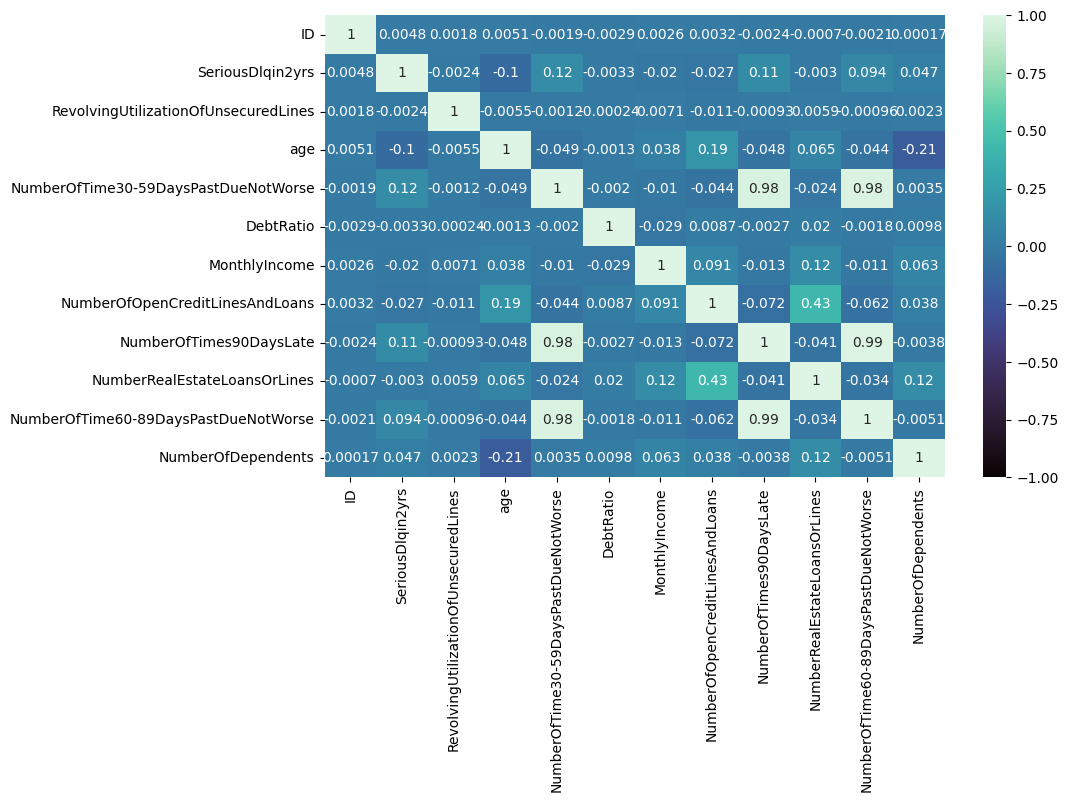

In [71]:
# Computing correlations
corr = df.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, vmin=-1.0, cmap="mako")

"NumberOfTimes90DaysLate", "NumberOfTimes60-89DatsPastDueNotWorse", and "NumberOfTime30-59DaysPastDueNotWorse" are highly correlated. Therefore, we can remove two columns, "NumberOfTimes60-89DatsPastDueNotWorse" and "NumberOfTime30-59DaysPastDueNotWorse.

<Axes: >

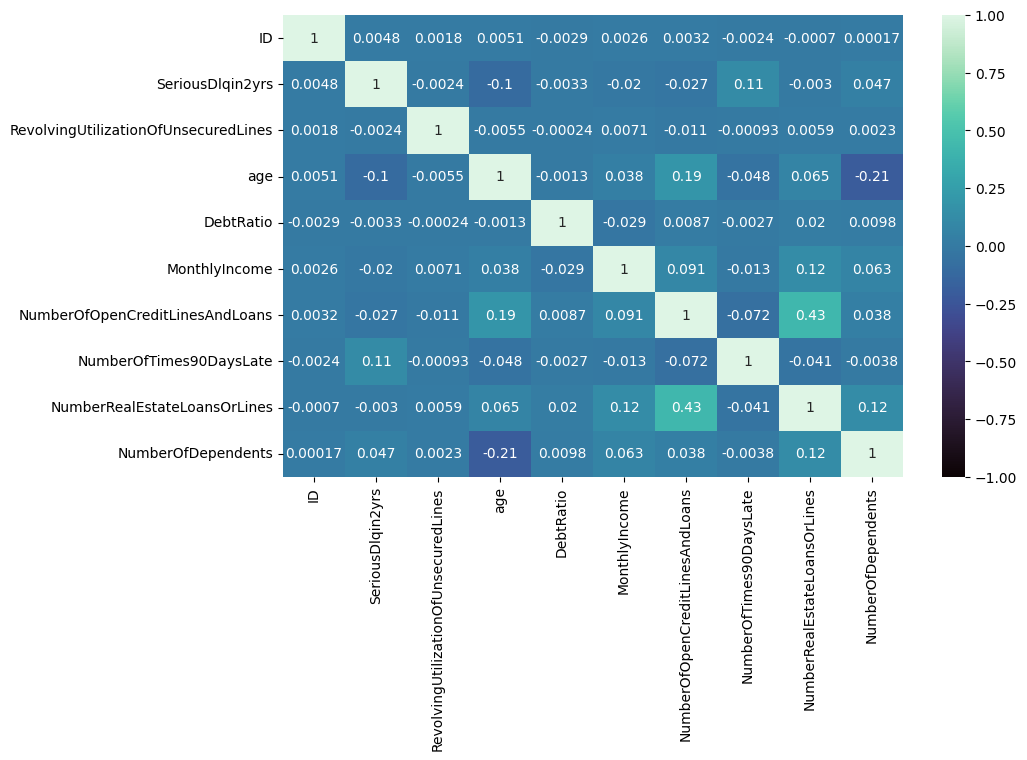

In [72]:
df = df.drop([ 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTime30-59DaysPastDueNotWorse'], axis = 1)

# Computing correlations again
corr = df.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, vmin=-1.0, cmap="mako")

### Plotting different graphs to look for Outliers

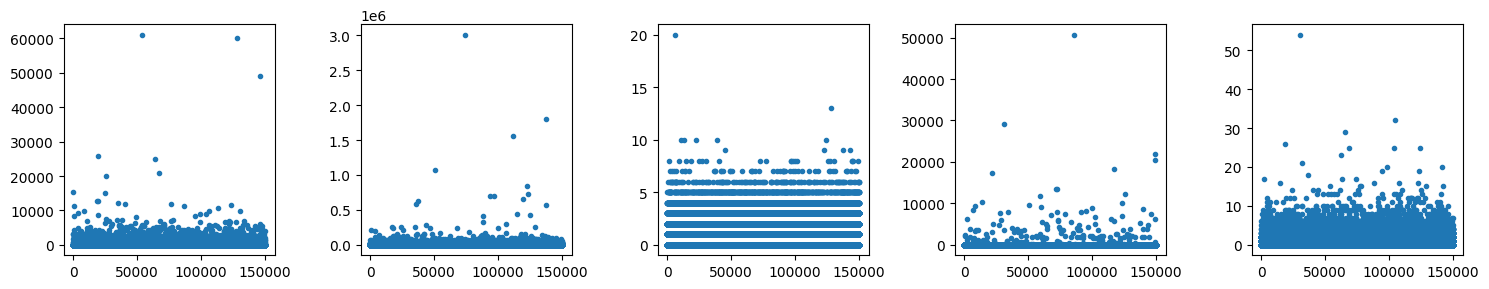

In [73]:
# Create a 2x3 subplot layout
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

# Flatten the axes array
axs = axs.flatten()
dfs = [df['DebtRatio'], df['MonthlyIncome'], df['NumberOfDependents'], df['RevolvingUtilizationOfUnsecuredLines'], df['NumberRealEstateLoansOrLines']]

for i, df_s in enumerate(dfs):
    axs.flatten()[i].scatter(df['ID'],df_s, marker = '.')

plt.tight_layout()
plt.show()

### Setting up some thresholds to get rid of some outliers based on the previous graphs

In [74]:
rows = df.shape[0] # No. of data points

df = df[df['DebtRatio']<=13000]
r_dr = rows - df.shape[0] # No. of Outliers removed using Debt Ratio

df = df[df['MonthlyIncome']<=200000]
r_mi = rows - r_dr - df.shape[0] # No. of Outliers removed using Monthly Income

df = df[df['NumberOfDependents']<=10]
r_nod = rows - r_dr - r_mi - df.shape[0] # No. of Outliers removed using Number of Dependents

df = df[df['RevolvingUtilizationOfUnsecuredLines']<=12500]
r_ruou = rows - r_dr - r_mi - r_nod - df.shape[0] # No. of Outliers removed using Revolving Utilization of Unsecured Lines

df = df[df['NumberRealEstateLoansOrLines']<=30]
r_nrelol = rows - r_dr - r_mi - r_nod - r_ruou - df.shape[0] # No. of Outliers removed using Number of Real Estate Loans Or Lines

print(f'Number of data points removed for Debt Ratio outliers {r_dr}, for Monthly income outliers {r_mi}, for no. of dependents {r_nod}, revolving utilization {r_ruou}, no. of loans or lines {r_nrelol}')

Number of data points removed for Debt Ratio outliers 9, for Monthly income outliers 29, for no. of dependents 2, revolving utilization 8, no. of loans or lines 2


### Plotting new graphs after removing the outliers

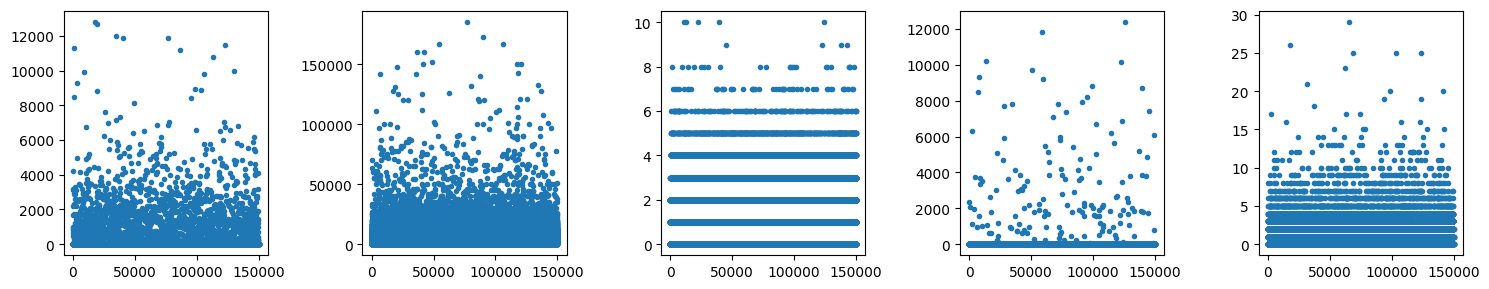

In [75]:
# Create a 2x3 subplot layout
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

# Flatten the axes array
axs = axs.flatten()
df2s = [df['DebtRatio'], df['MonthlyIncome'], df['NumberOfDependents'], df['RevolvingUtilizationOfUnsecuredLines'], df['NumberRealEstateLoansOrLines']]

for i, df_s in enumerate(df2s):
    axs.flatten()[i].scatter(df['ID'],df_s, marker = '.')

plt.tight_layout()
plt.show()

Now the graphs don't seem to have outliers. Because we did not remove too many rows (less than 0.1%), the model should give us better results.